<a href="https://colab.research.google.com/github/KTH-EXPECA/summer-school-2025/blob/main/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p /content/data
!curl -L -o /content/data/dataset.zip "https://github.com/KTH-EXPECA/summer-school-2025/raw/refs/heads/main/dataset.zip"
!unzip -q -o /content/data/dataset.zip
!rm -rf /content/data
!rm -rf /content/__MACOSX
!pip install pandas numpy


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20.5M  100 20.5M    0     0  13.3M      0  0:00:01  0:00:01 --:--:-- 23.4M


In [2]:
import pickle, json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pkl_path = Path("/content/dataset.pkl")
with open(pkl_path, "rb") as f:
    datasets = pickle.load(f)

for i, item in enumerate(datasets, 1):
    df = pd.DataFrame(item.get("dataset"))
    meta = {k: v for k, v in item.items() if k != "dataset"}

    print(f"\n===== ITEM {i} =====")
    print("META:", meta)
    print(f"DATASET: DataFrame shape={df.shape}, columns:{df.columns}")


===== ITEM 1 =====
META: {'db_id': 0, 'dataset_name': 'e20', 'stream_rnti': '77e2', 'size': 90306, 'arrivals_num': 18061}
DATASET: DataFrame shape=(90306, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len',
       'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols',
       'time_since_start', 'time_since_last_event'],
      dtype='object')

===== ITEM 2 =====
META: {'db_id': 1, 'dataset_name': 'e4', 'stream_rnti': 'a431', 'size': 146421, 'arrivals_num': 36602}
DATASET: DataFrame shape=(146421, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len',
       'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols',
       'time_since_start', 'time_since_last_event'],
      dtype='object')

===== ITEM 3 =====
META: {'db_id': 2, 'dataset_name': 'e19', 'stream_rnti': '37ff', 'size': 89016, 'arrivals_num': 18058}
DATASET: DataFrame shape=(89016, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_

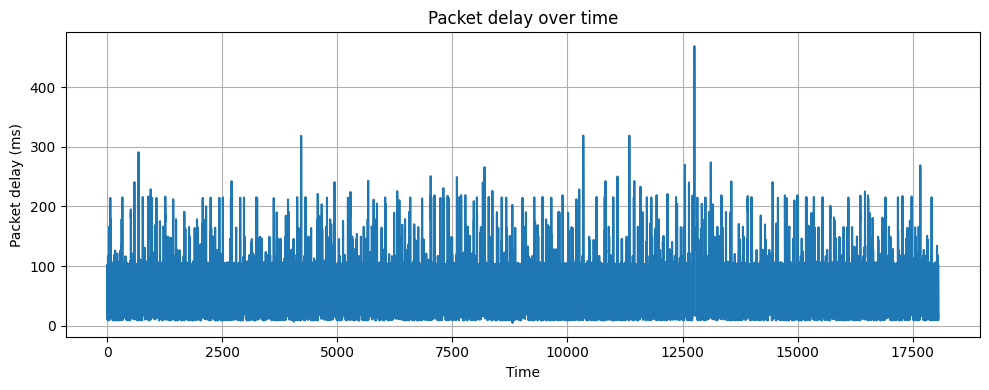

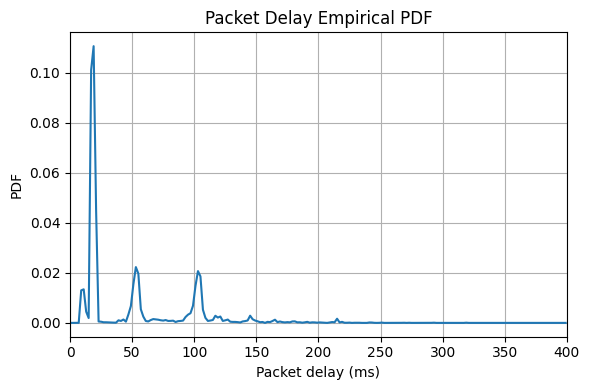

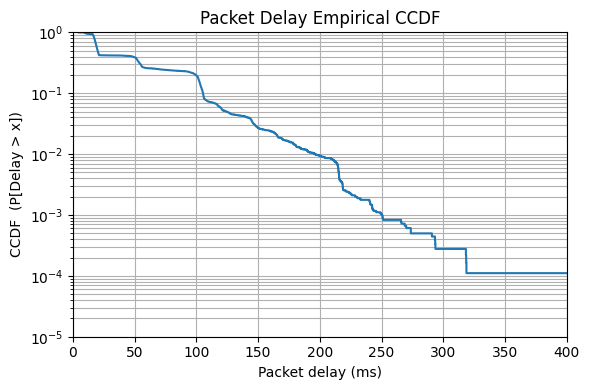

In [4]:
df = pd.DataFrame(datasets[0]['dataset'])
df = df.loc[df['segment'] == -1].copy()

df['packet_delay_ms'] = (df['depart_timestamp'].astype(float) - df['timestamp'].astype(float)) * 1000
packet_delays_ms = df['packet_delay_ms'].tolist()

plt.figure(figsize=(10, 4))
plt.plot(df['packet_delay_ms'].values)
plt.xlabel('Time')
plt.ylabel('Packet delay (ms)')
plt.title('Packet delay over time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Use the same delays column you computed
delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()

# Keep only [0, 400] ms for the plot domain
mask = (delays >= 0) & (delays <= 400)
delays_clip = delays[mask]

# Histogram as PDF (area = 1). 2 ms bins across 0–400 ms -> 200 bins
bins = np.linspace(0, 400, 201)
pdf_vals, bin_edges = np.histogram(delays_clip, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, pdf_vals)
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('PDF')
plt.title('Packet Delay Empirical PDF')
plt.grid(True)
plt.tight_layout()
plt.show()

# calculate CCDF
delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()
delays.sort()                              # ascending
n = delays.size
ccdf = 1.0 - (np.arange(1, n + 1) / n)     # empirical CCDF = 1 - ECDF

# plot CCDF
plt.figure(figsize=(6, 4))
plt.step(delays, ccdf, where='post')       # survival curve style
plt.yscale('log')
plt.xlim(0, 400)
plt.ylim(1e-5, 1)
plt.xlabel('Packet delay (ms)')
plt.ylabel('CCDF  (P[Delay > x])')
plt.title('Packet Delay Empirical CCDF')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()




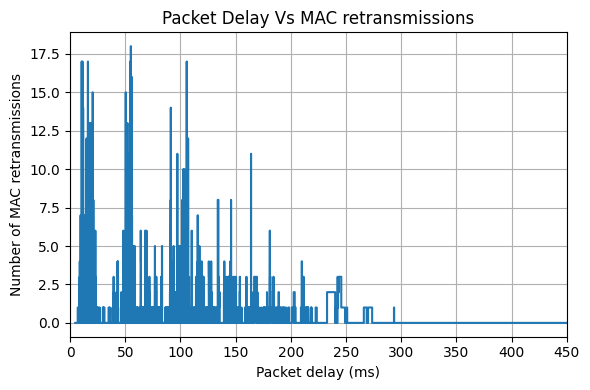

In [5]:
# Get the no of mac retransmissions
mretx = df['mretx'].tolist()

# plot delay distribution over the number of mac retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, mretx, where='post')       # survival curve style
plt.xlim(0, 450)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of MAC retransmissions')
plt.title('Packet Delay Vs MAC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

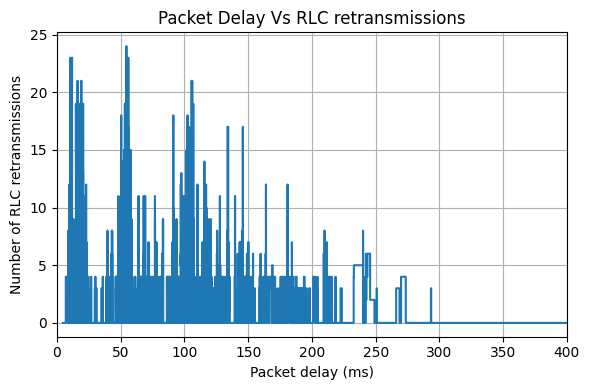

In [6]:
# Get the no of rlc retransmissions
rlcRetx = df['rfailed'].tolist()

# plot delay distribution over the number of rlc retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, rlcRetx, where='post')       # survival curve style
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of RLC retransmissions')
plt.title('Packet Delay Vs RLC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

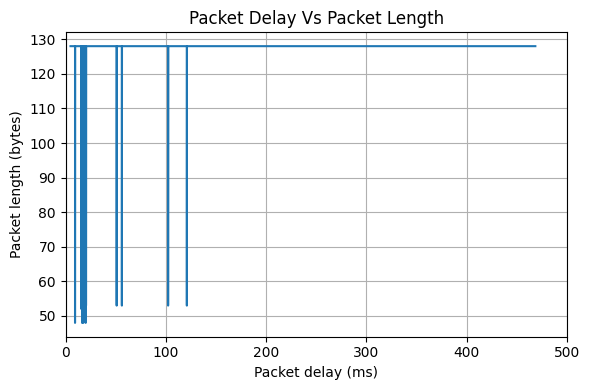

In [7]:
# Get the packet length
pktLen = df['len'].tolist()

# plot delay distribution over the packet length
plt.figure(figsize=(6, 4))
plt.step(delays, pktLen, where='post')       # survival curve style
plt.xlim(0, 500)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Packet length (bytes)')
plt.title('Packet Delay Vs Packet Length')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()